In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import pfjax as pf
from pfjax import proj_data, PGNETModel

key = random.PRNGKey(0)

# parameter values

theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
tau = np.array([1,1,1,1])*0.25
theta = np.append(theta, tau)
dt = .1
n_res = 2
n_obs = 50
pgnet_model = PGNETModel(dt, n_res)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_model, subkey, n_obs, x_init, theta)


Text(0.5, 1.0, 'Observations and Latent')

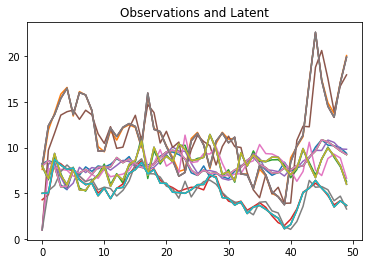

In [3]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(y_meas[:, 2])
plt.plot(y_meas[:, 3])
plt.plot(np.exp(x_state[:,0]))
plt.plot(np.exp(x_state[:, 1]))
plt.plot(np.exp(x_state[:, 2]))
plt.plot(np.exp(x_state[:, 3]))
plt.title("Observations and Latent")

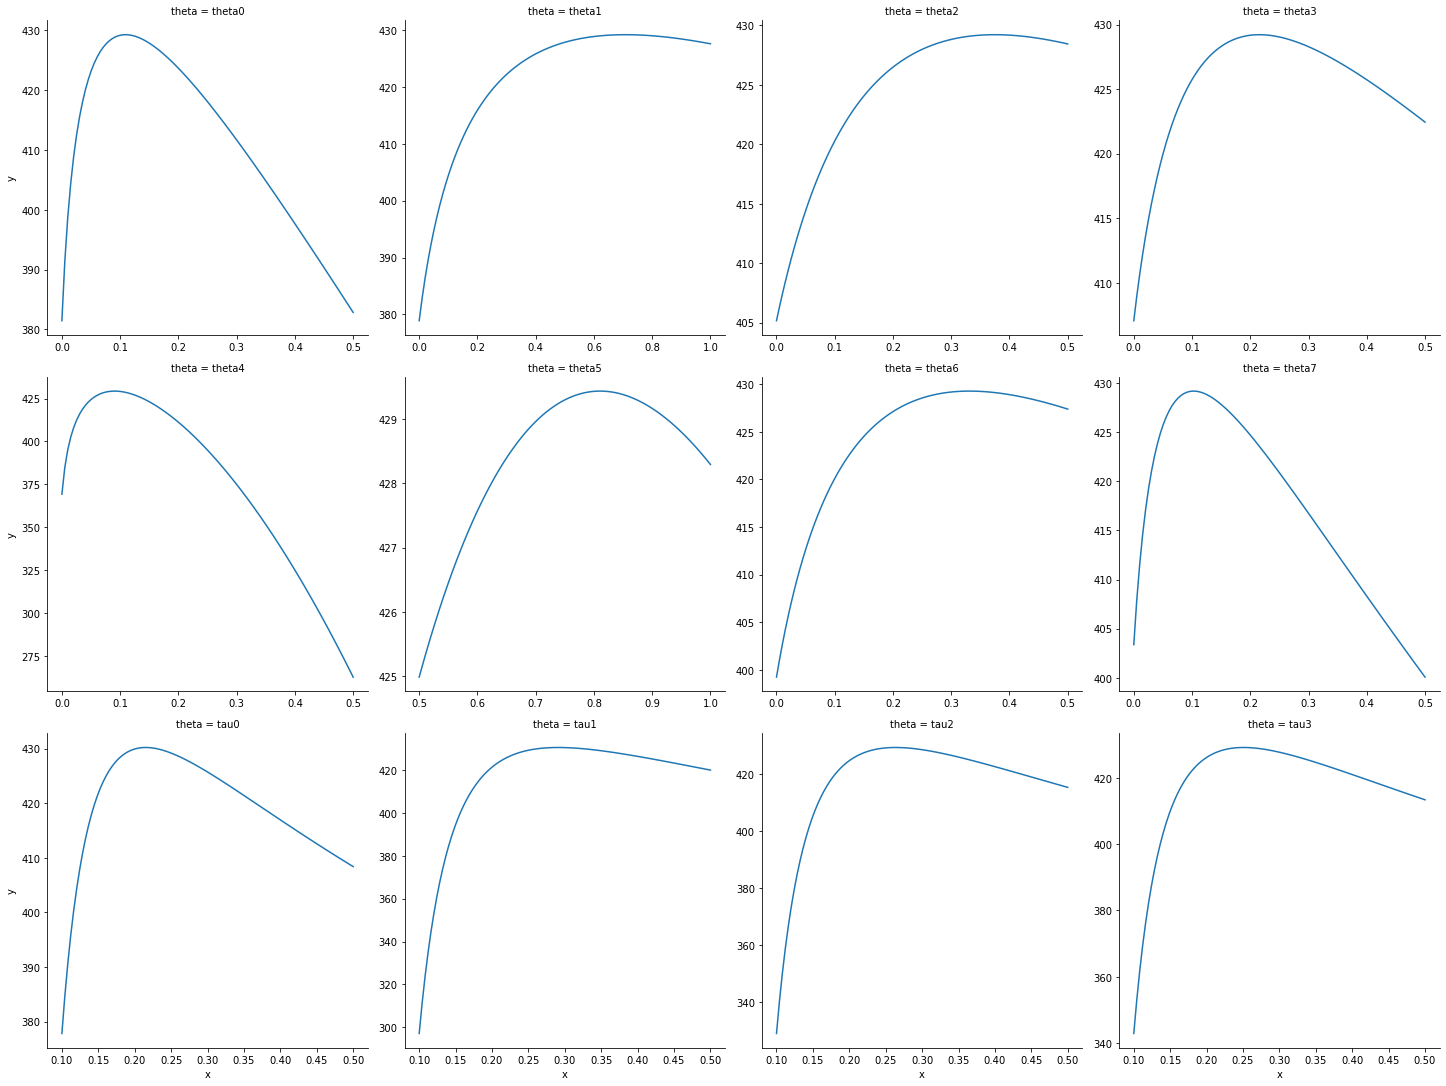

In [5]:
theta_lims = np.array([[0, 0.5], [0,1], [0, 0.5], [0, 0.5], [0, 0.5], [0.5, 1], [0, 0.5], [0, 0.5],
                     [.1, .5], [.1, .5], [.1, .5], [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]
n_pts = 100

# calculate projection plot


@jax.jit
def pgnet_loglik(theta):
    return pf.full_loglik(model=pgnet_model, theta=theta, x_state=x_state, y_meas=y_meas)


plot_df = proj_data(pgnet_loglik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

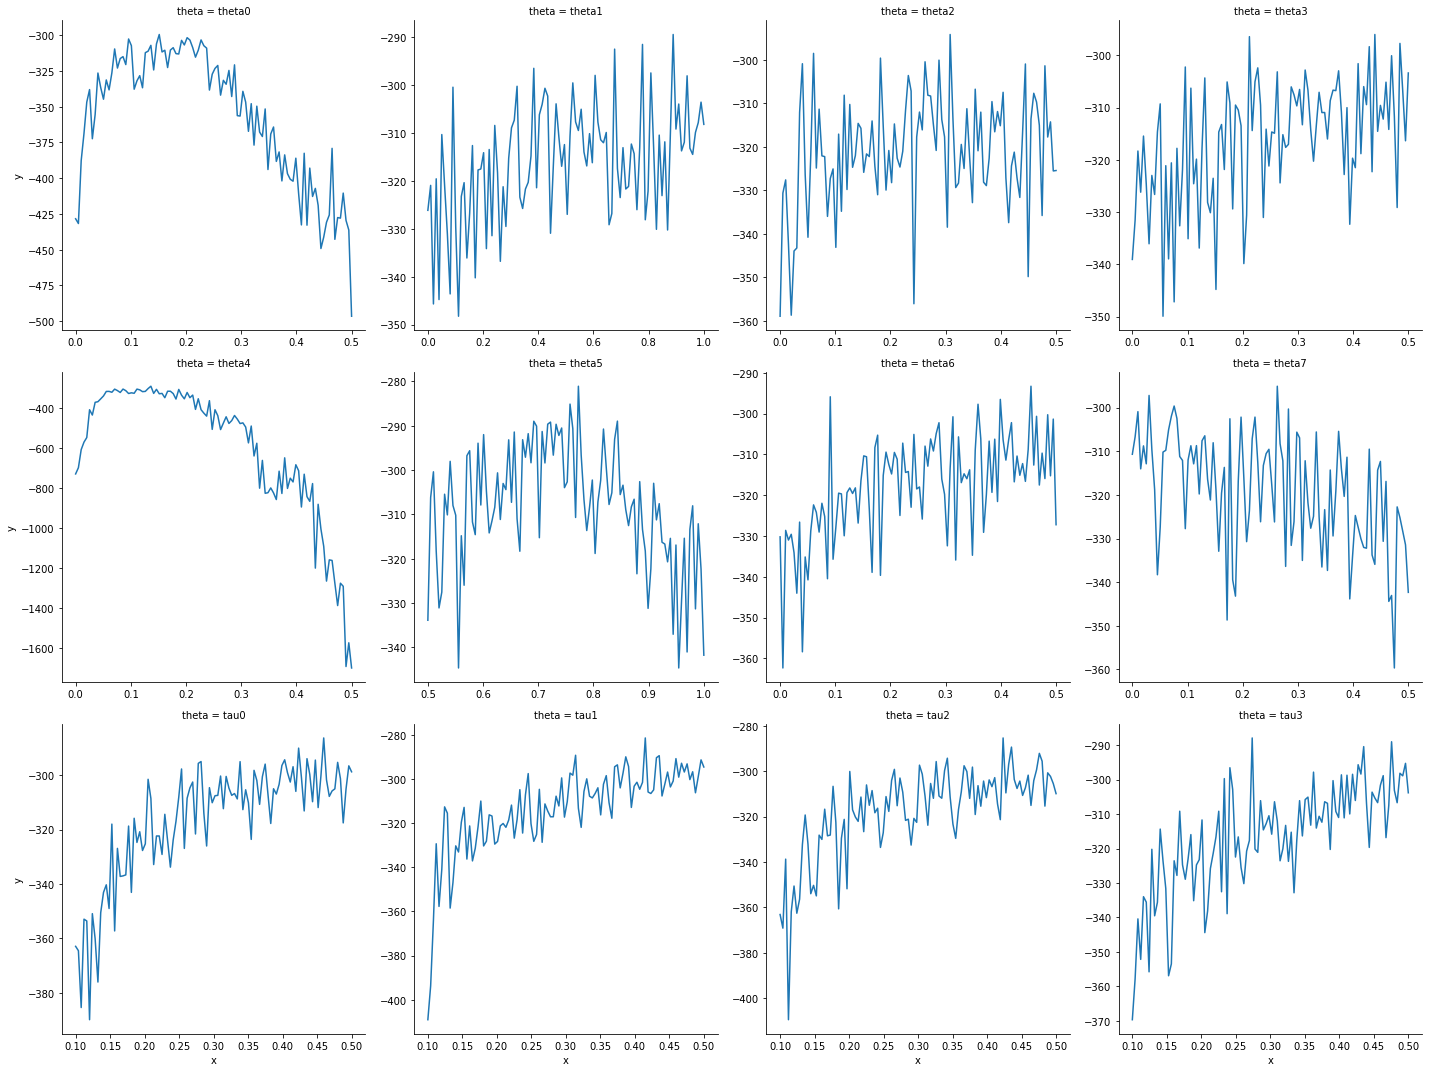

In [5]:
theta_lims = np.array([[0, 0.5], [0,1], [0, 0.5], [0, 0.5], [0, 0.5], [0.5, 1], [0, 0.5], [0, 0.5],
                     [.1, .5], [.1, .5], [.1, .5], [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]
n_pts = 100

# calculate projection plot
n_particles = 1000

@jax.jit
def pgnet_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=pgnet_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(pgnet_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [4]:
theta_lims = np.array([[0, 0.5], [0,1], [0, 0.5], [0, 0.5], [0, 0.5], [0.5, 1], [0, 0.5], [0, 0.5],
                     [.1, .5], [.1, .5], [.1, .5], [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]
n_pts = 100

# calculate projection plot
n_particles = 1000

particles = pf.particle_filter(theta=theta, model=pgnet_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    

In [5]:
logw = particles['logw'][1:]
x_particles = particles['x_particles'][1:]
x_sample = np.zeros((n_obs*n_res, 4))
x_mean = np.zeros((n_obs*n_res, 4))
x_cov = np.zeros((n_obs*n_res, 4, 4))
x_sample[0:2] = x_init
x_mean[0:2] = x_init

for i in range(logw.shape[0]):
    wgt = jnp.exp(logw[i] - jnp.max(logw[i]))
    prob = wgt / jnp.sum(wgt)
    ind = random.choice(key, a=n_particles, p=prob)
    x_sample[2*(i+1):2*(i+2)] = x_particles[i][ind]
    x_mean[2*(i+1):2*(i+2)] = np.average(x_particles[i], axis=0, weights=prob)
    x_cov[2*(i+1):2*(i+1)+1] = np.cov(x_particles[i,:,0], rowvar=False, aweights=prob)
    x_cov[2*(i+1)+1:2*(i+2)] = np.cov(x_particles[i,:,1], rowvar=False, aweights=prob)
    

Text(0.5, 1.0, 'Bootstrap samples')

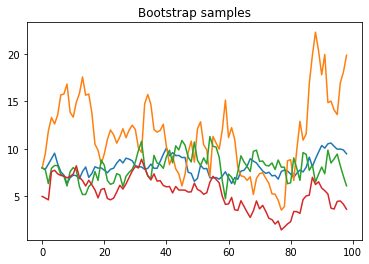

In [6]:
import matplotlib.pyplot as plt
plt.plot(np.exp(x_sample[1:, 0]))
plt.plot(np.exp(x_sample[1:, 1]))
plt.plot(np.exp(x_sample[1:, 2]))
plt.plot(np.exp(x_sample[1:, 3]))
plt.title("Bootstrap samples")

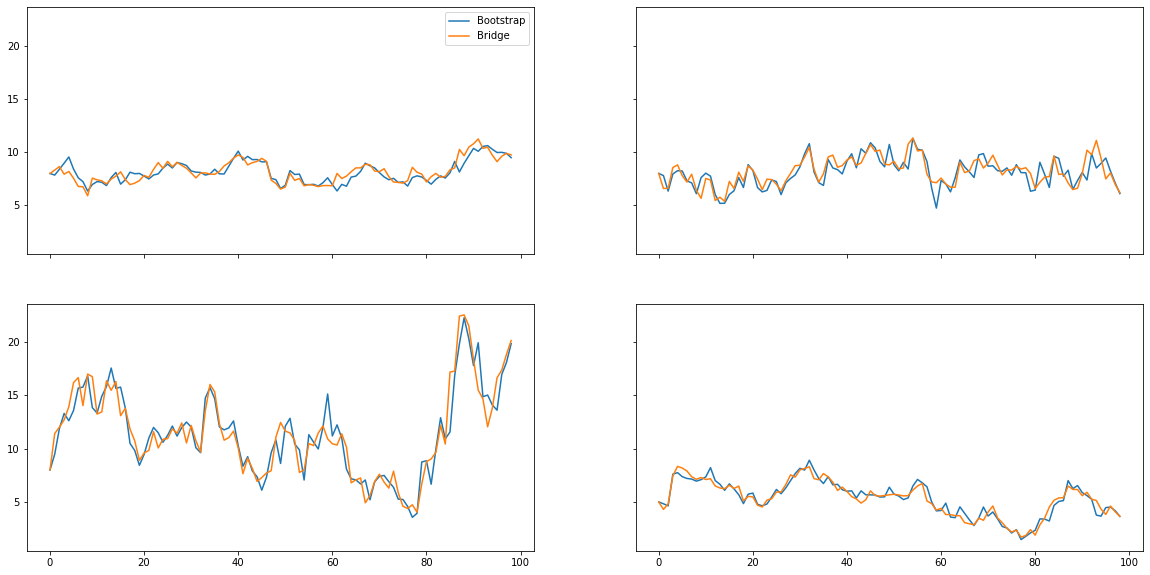

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20,10))
axs[0, 0].plot(np.exp(x_sample[1:, 0]), label='Bootstrap')
axs[0, 0].plot(np.exp(x_sample2[1:, 0]), label='Bridge')
axs[1, 0].plot(np.exp(x_sample[1:, 1]), label='Bootstrap')
axs[1, 0].plot(np.exp(x_sample2[1:, 1]), label='Bridge')
axs[0, 1].plot(np.exp(x_sample[1:, 2]), label='Bootstrap')
axs[0, 1].plot(np.exp(x_sample2[1:, 2]), label='Bridge')
axs[1, 1].plot(np.exp(x_sample[1:, 3]), label='Bootstrap')
axs[1, 1].plot(np.exp(x_sample2[1:, 3]), label='Bridge')

axs[0, 0].legend()

In [11]:
particles2 = particle_filter2(theta=theta, model=pgnet_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)

In [12]:
logw = particles2['logw'][1:]
x_particles2 = particles2['x_particles'][1:]
x_sample2 = np.zeros((n_obs*n_res, 4))
x_mean2 = np.zeros((n_obs*n_res, 4))
x_cov2 = np.zeros((n_obs*n_res, 4, 4))
x_sample2[0:2] = x_init
x_mean2[0:2] = x_init

for i in range(logw.shape[0]):
    wgt = jnp.exp(logw[i] - jnp.max(logw[i]))
    prob = wgt / jnp.sum(wgt)
    ind = random.choice(key, a=n_particles, p=prob)
    x_sample2[2*(i+1):2*(i+2)] = x_particles2[i][ind]
    x_mean2[2*(i+1):2*(i+2)] = np.average(x_particles2[i], axis=0, weights=prob)
    x_cov2[2*(i+1):2*(i+1)+1] = np.cov(x_particles2[i,:,0], rowvar=False, aweights=prob)
    x_cov2[2*(i+1)+1:2*(i+2)] = np.cov(x_particles2[i,:,1], rowvar=False, aweights=prob)
    

In [10]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random
from jax import lax
from jax.experimental.maps import xmap

def particle_filter2(model, key, y_meas, theta, n_particles,
                    particle_sampler=pf.particle_resample):

    n_obs = y_meas.shape[0]

    # lax.scan setup
    # scan function
    def fun(carry, t):
        # sample particles from previous time point
        key, subkey = random.split(carry["key"])
        new_particles = particle_sampler(subkey,
                                         carry["x_particles"],
                                         carry["logw"])
        # update particles to current time point (and get weights)
        key, *subkeys = random.split(key, num=n_particles+1)
        x_particles, logw = jax.vmap(
            lambda xs, k: model.bridge_prop(k, xs, y_meas[t], theta, jnp.eye(4), jnp.eye(4))
        )(new_particles["x_particles"], jnp.array(subkeys))
        # breakpoint()
        # output
        res_carry = {
            "x_particles": x_particles,
            "logw": logw,
            "key": key
        }
        res_stack = new_particles
        res_stack["x_particles"] = x_particles
        res_stack["logw"] = logw
        return res_carry, res_stack
    # scan initial value
    key, *subkeys = random.split(key, num=n_particles+1)
    # vmap version
    x_particles, logw = jax.vmap(
        lambda k: model.pf_init(k, y_meas[0], theta))(jnp.array(subkeys))
    # xmap version: experimental!
    # x_particles = xmap(
    #     lambda ym, th, k: model.init_sample(ym, th, k),
    #     in_axes=([...], [...], ["particles", ...]),
    #     out_axes=["particles", ...])(y_meas[0], theta, jnp.array(subkeys))
    # logw = xmap(
    #     lambda xs, ym, th: model.init_logw(xs, ym, th),
    #     in_axes=(["particles", ...], [...], [...]),
    #     out_axes=["particles", ...])(x_particles, y_meas[0], theta)
    init = {
        "x_particles": x_particles,
        "logw": logw,
        "key": key
    }
    # lax.scan itself
    last, full = lax.scan(fun, init, jnp.arange(1, n_obs))
    # append initial values of x_particles and logw
    full["x_particles"] = jnp.append(
        jnp.expand_dims(init["x_particles"], axis=0),
        full["x_particles"], axis=0)
    full["logw"] = jnp.append(
        jnp.expand_dims(init["logw"], axis=0),
        full["logw"], axis=0)
    return full